In [1]:
import matplotlib.pyplot as plt
import mne
import mne_icalabel
import numpy as np
import torch
from braindecode.models import EEGInceptionERP, SignalJEPA
from mne.preprocessing import ICA
from scipy.fft import rfft, rfftfreq
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

Get filename

In [2]:
filename = "user_18_session_1"

Open BDF file

In [3]:
raw = mne.io.read_raw_bdf(f"C:/Users/Iraklis Kolokas/Desktop/Thesis/EEG/{filename}.bdf", preload = True)

Extracting EDF parameters from C:\Users\Iraklis Kolokas\Desktop\Thesis\EEG\user_18_session_1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 401407  =      0.000 ...   196.000 secs...


Get Events through trigger(Status) channel

In [4]:
events = mne.find_events(raw, stim_channel = "Status", shortest_event = 1)

Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
15 events found on stim channel Status
Event IDs: [2]


Remove unused BioSemi channels

In [5]:
keep_ch = raw.ch_names[:32] + ["Status"]
raw = raw.pick(keep_ch)

Deleta data recorded before the experiment starts

In [6]:
first_stim = events[events[:, 2] == 2][0, 0] #find the first code 2 event in frames
last_stim = events[events[:, 2] == 2][-1, 0]
first_stim_time = raw.times[first_stim]
last_stim_time = raw.times[last_stim]
start_time = max(2.0, first_stim_time - 2.0)
end_time = min(raw.times[-1], last_stim_time  + 1.5  # stim duration
                                              + 3.0  # extra time until resting state screen closes
                                              + 0.3) # extra time to be sure    

raw.crop(tmin = start_time, tmax = end_time)

<RawEDF | user_18_session_1.bdf, 33 x 350212 (171.0 s), ~88.2 MiB, data loaded>

Recalculate events

In [7]:
events = mne.find_events(raw, stim_channel = "Status", shortest_event = 1)

Finding events on: Status
15 events found on stim channel Status
Event IDs: [2]


Label Acoustic Stimuli

Create epochs

In [8]:
#Reject = None, to label all the epochs 
epochs = mne.Epochs(raw, events = events, tmin = -0.3, tmax = 2.5, baseline = (None, 0), preload = True, reject = None)
sfreq = raw.info["sfreq"]

Not setting metadata
15 matching events found
Setting baseline interval to [-0.2998046875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15 events and 5735 original time points ...
0 bad epochs dropped


Check Magnitute for the frequencies of the Acoustic Stimuli

In [9]:
def check_freq_magnitude(target_freq, epochs, sfreq, number_of_epochs = 5):    
    power = []

    for ep_idx, epoch_data in enumerate(epochs.get_data()): 
        # enumerate adds index 
        # epoch.get_data() : (n_channels, n_times)
        fft_vals = np.fft.rfft(epoch_data, axis = 1)  # FFT along time axis for each channel
    
        freqs = np.fft.rfftfreq(epoch_data.shape[1], d = 1/sfreq)
        # Computes frequency values for the rfft bins above
        
        magnitude = np.abs(fft_vals)
        # |x|

        # Find closest bin to 500 Hz
        bin_idx = np.argmin(np.abs(freqs - target_freq))

        # Average magnitude at 500 Hz across channels
        mean_power = magnitude[:, bin_idx].mean()
        power.append(mean_power)

    power = np.array(power)

    #Select top 5 epochs with biggest magnitude 
    top_5 = np.argsort(power)[-number_of_epochs:][::-1]
    
    return top_5

Hierarchical Clustering Algorithm (Central-Region-Based)

In [10]:
# create the central region 
def central_region_area(curves):
    median = np.median(curves, axis = 0)
    lower = np.percentile(curves, 25, axis = 0)
    upper = np.percentile(curves, 75, axis = 0)
    return np.sum(upper - lower)  # integrated width

# compute the distance of the central regions
def cr_distance(X, Y):
    merged = np.vstack([X, Y])
    return central_region_area(merged)

In [11]:
# compute fft curves 
def CR_Hier_clustering(epochs, n_clusters = 3):
    fft_curves = []
    freqs = None

    for ep_idx, epoch_data in enumerate(epochs.get_data()):  # (n_channels, n_times)
        fft_vals = np.fft.rfft(epoch_data, axis = 1)
        magnitude = np.abs(fft_vals)

        # Store frequency bins (same for all epochs)
        if freqs is None:
            freqs = np.fft.rfftfreq(epoch_data.shape[1], d = 1/sfreq)

        # Average across channels to get a single curve
        mean_curve = magnitude.mean(axis = 0)  # (n_freqs,)
        fft_curves.append(mean_curve)

    #All epochs stored together
    fft_curves = np.array(fft_curves)  # shape: (n_epochs, n_freqs)

    # Assume `fft_curves` is (n_epochs, n_freq_bins) array
    n = len(fft_curves)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist = cr_distance(fft_curves[i:i+1], fft_curves[j:j+1])
            dist_matrix[i, j] = dist_matrix[j, i] = dist

    clustering = AgglomerativeClustering(
        n_clusters = n_clusters,
        metric = 'precomputed',
        linkage = 'average'
    )
    labels = clustering.fit_predict(dist_matrix)
    
    return labels, fft_curves, freqs

Find which epoch is in each cluster

In [12]:
#Get cluster labels, data after fft and the frequency bins
labels, fft_curves , freqs = CR_Hier_clustering(epochs, 3)

In [13]:
#Dictionary with every epoch in each respective cluster
epochs_in_clusters = {}
for cluster_id in np.unique(labels):
    epochs_in_clusters[cluster_id] = np.where(labels == cluster_id)[0].tolist() # indices of epochs

for cluster_id, epoch_indices in epochs_in_clusters.items():
    print(f"Cluster {cluster_id}: epochs {epoch_indices}")

Cluster 0: epochs [3, 5, 6, 7, 8, 13]
Cluster 1: epochs [0, 11]
Cluster 2: epochs [1, 2, 4, 9, 10, 12, 14]


Find which frequency each cluster corresponds to

In [14]:
# Store powers per cluster in dictonary
mean_power = {cluster_id: {} for cluster_id in np.unique(labels)}

# Get FFT for each cluster from ff_curves
for cluster_id in np.unique(labels):
    idx = np.where(labels == cluster_id)[0]
    cluster_data = fft_curves[idx]  # (n_epochs_in_cluster, n_freqs)

    print(f"Cluster {cluster_id}: epochs {idx.tolist()}")

    for target_freq in [500, 48, 96]:  
        # Find closest bin to target frequencies
        bin_idx = np.argmin(np.abs(freqs - target_freq))
        power_val = cluster_data[:, bin_idx].mean()
        #Mean power of each cluster at each frequency
        mean_power[cluster_id][target_freq] = power_val
        print(f"  Power {target_freq} Hz : {power_val:.6f}")

Cluster 0: epochs [3, 5, 6, 7, 8, 13]
  Power 500 Hz : 0.043538
  Power 48 Hz : 0.483006
  Power 96 Hz : 0.174946
Cluster 1: epochs [0, 11]
  Power 500 Hz : 0.021414
  Power 48 Hz : 0.531033
  Power 96 Hz : 0.118333
Cluster 2: epochs [1, 2, 4, 9, 10, 12, 14]
  Power 500 Hz : 0.021426
  Power 48 Hz : 0.530994
  Power 96 Hz : 0.118199


Assign based on power the 500Hz label and check if any other cluster has almost the same power 

In [15]:
top5_500 = check_freq_magnitude(500, epochs, sfreq)
max = mean_power[0][500]
cl_500 = 0
for cluster_id in np.unique(labels):
    if mean_power[cluster_id][500] > max:
        max = mean_power[cluster_id][500]
        cl_500 = cluster_id
for cluster_id in np.unique(labels):
    if max / mean_power[cluster_id][500] < 1.2 and cl_500 != cluster_id: 
        # chose top5_500 as one cluster and recluster the rest of the data
        
        cl_500 = 2

        #all epochs
        all_indices = np.arange(len(epochs))
        # Keep the rest
        keep_indices = np.setdiff1d(all_indices, top5_500)
        epochs_to_cluster = epochs[keep_indices]

        labels, fft_curves , freqs = CR_Hier_clustering(epochs_to_cluster, 2)

        #Dictionary with every epoch in each respective cluster
        epochs_in_clusters = {}
        for cluster_id in np.unique(labels):
            epochs_in_clusters[cluster_id] = np.where(labels == cluster_id)[0].tolist()  # indices of epochs

        for cluster_id, epoch_indices in epochs_in_clusters.items():
            print(f"Cluster {cluster_id}: epochs {epoch_indices}")

        epochs_in_clusters[2] = top5_500
        

Transform all dictionary inputs to ints

In [16]:
epochs_in_clusters = {y: [int(x) for x in v] for y, v in epochs_in_clusters.items()}

Find the frequencies for the rest of the clusters

In [17]:
#Check to find which other cluster contain which frequency stimulis
remaining_cluster = list(set(np.unique(labels)) - {cl_500}) 
cl_other = remaining_cluster[0] #random cluster from the remaining

max = mean_power[cl_other][96]
cl_4000 = cl_other
for cluster_id in set(np.unique(labels)) - {cl_500}:
    if mean_power[cluster_id][96] > max:
        max = mean_power[cluster_id][96]
        cl_4000 = cluster_id

max = mean_power[cl_other][48]
cl_2000 = cl_other
for cluster_id in set(np.unique(labels)) - {cl_500}:
    if mean_power[cluster_id][48] > max:
        max = mean_power[cluster_id][48]
        cl_2000 = cluster_id


#Check which has more power between one another in case they are assigned the same cluster name 
if cl_2000 == cl_4000:
    remaining_cluster = list(set(np.unique(labels)) - {cl_500, cl_2000}) 
    #need cl_other because I can't pass a list to a dict (mean_power[remaining_cluster])
    cl_other = remaining_cluster[0] 

    #The one that drops more if it changes stays the same
    if mean_power[cl_2000][48]/ mean_power[cl_other][48] > mean_power[cl_4000][96]/mean_power[cl_other][96]:
        cl_4000 = list(set(np.unique(labels)) - {cl_500, cl_2000})[0]

    else:
        cl_2000 = list(set(np.unique(labels)) - {cl_500, cl_2000})[0]

Find excess epochs

In [18]:
def excess_epochs(freq, cl_number, epochs_in_clusters, epochs, sfreq, check = "under"):
    #Gets the fist or last from the list until 5 remain
    if check == "under":
        #Get the correct order of the epochs(in terms of power) 
        common = [x for x in check_freq_magnitude(freq, epochs, sfreq, 15) if x in epochs_in_clusters[cl_number]]
        #Select from the bottom so that when I remove them from the list the sum will be 5
        removed_list = common[-(len(epochs_in_clusters[cl_number]) - 5):] 
        removed_list = [int(x) for x in removed_list]
        #Remove them from the list
        epochs_in_clusters[cl_number] = list(set(epochs_in_clusters[cl_number]) - set(removed_list))
    else: 
        #Get the correct order of the epochs(in terms of power)
        common = [x for x in check_freq_magnitude(freq, epochs, sfreq, 15) if x not in epochs_in_clusters[cl_number]]
        #Select from the top so that when I add them to the list the sum will be 5
        removed_list = common[:(5 - len(epochs_in_clusters[cl_number]))]
        removed_list = [int(x) for x in removed_list]
        #Add them to the list
        epochs_in_clusters[cl_number] = list(epochs_in_clusters[cl_number]) + list(removed_list)

    return removed_list

Make each cluster have 5 epochs

In [19]:
#Check cl_500 to get which has the epochs with the epochs with the most 500Hz power
removed_list = []
if len(epochs_in_clusters[cl_500]) > 5:

    removed_list = excess_epochs(500, cl_500, epochs_in_clusters, epochs, sfreq)
    #Check the contents of the rest of the lists
    if len(epochs_in_clusters[cl_2000]) > len(epochs_in_clusters[cl_4000]):
        epochs_in_clusters[cl_4000] = list(epochs_in_clusters[cl_4000]) + list(removed_list) 
        if len(epochs_in_clusters[cl_4000]) > 5:
            removed_list = excess_epochs(96, cl_4000, epochs_in_clusters, epochs, sfreq)
            epochs_in_clusters[cl_2000] = list(epochs_in_clusters[cl_2000]) + list(removed_list)
        elif len(epochs_in_clusters[cl_4000]) < 5:
            removed_list = excess_epochs(48, cl_2000, epochs_in_clusters, epochs, sfreq)
            epochs_in_clusters[cl_4000] = list(epochs_in_clusters[cl_4000]) + list(removed_list)
    #The opposite if len(cl_2000)<len(cl_4000)
    else:
        epochs_in_clusters[cl_2000] = list(epochs_in_clusters[cl_2000]) + list(removed_list)  
        if len(epochs_in_clusters[cl_2000]) > 5:
            removed_list = excess_epochs(48, cl_2000, epochs_in_clusters, epochs, sfreq)
            epochs_in_clusters[cl_4000] = list(epochs_in_clusters[cl_4000]) + list(removed_list)
        elif len(epochs_in_clusters[cl_2000]) < 5:
            removed_list = excess_epochs(96, cl_4000, epochs_in_clusters, epochs, sfreq)
            epochs_in_clusters[cl_2000] = list(epochs_in_clusters[cl_2000]) + list(removed_list)

elif len(epochs_in_clusters[cl_500]) < 5 :
    #Get the epochs with the most power at 500Hz
    removed_list = excess_epochs(500, cl_500, epochs_in_clusters, epochs, sfreq, check = "over")
    #Check where the epochs are from and remove them 
    for ep in removed_list:
        if ep in epochs_in_clusters[cl_2000]:
            epochs_in_clusters[cl_2000].remove(ep)
        else:
            epochs_in_clusters[cl_4000].remove(ep)
    
    #Then check the lengths of the rest of clusters an fix them
    if len(epochs_in_clusters[cl_2000]) > len(epochs_in_clusters[cl_4000]):
        removed_list = excess_epochs(48, cl_2000, epochs_in_clusters, epochs, sfreq)
        epochs_in_clusters[cl_4000] = list(epochs_in_clusters[cl_4000]) + list(removed_list)
    
    #The opposite if len(cl_2000)<len(cl_4000)
    elif len(epochs_in_clusters[cl_2000]) < len(epochs_in_clusters[cl_4000]):
        removed_list = excess_epochs(96, cl_4000, epochs_in_clusters, epochs, sfreq)
        epochs_in_clusters[cl_2000] = list(epochs_in_clusters[cl_2000]) + list(removed_list)

else:
    #Then check the lengths of the rest of clusters an fix them
    if len(epochs_in_clusters[cl_2000]) > len(epochs_in_clusters[cl_4000]):
        removed_list = excess_epochs(48, cl_2000, epochs_in_clusters, epochs, sfreq)
        epochs_in_clusters[cl_4000] = list(epochs_in_clusters[cl_4000]) + list(removed_list)
    
    #The opposite if len(cl_2000) < len(cl_4000)
    elif len(epochs_in_clusters[cl_2000]) < len(epochs_in_clusters[cl_4000]):
        removed_list = excess_epochs(96, cl_4000, epochs_in_clusters, epochs, sfreq)
        epochs_in_clusters[cl_2000] = list(epochs_in_clusters[cl_2000]) + list(removed_list)

In [20]:
print(epochs_in_clusters[cl_500])
print(epochs_in_clusters[cl_2000])
print(epochs_in_clusters[cl_4000])

[3, 5, 6, 7, 13]
[1, 2, 10, 12, 14]
[0, 11, 8, 9, 4]


Change the cluster sequence

In [21]:
epochs_in_clusters[cl_500], epochs_in_clusters[cl_2000], epochs_in_clusters[cl_4000] = epochs_in_clusters[0], epochs_in_clusters[1], epochs_in_clusters[2]
cl_500 = 0
cl_2000 = 1
cl_4000 = 2

Drift removal

In [22]:
#Filter to remove both drifts (high-pass) and get the signal ready for ICA (low-pass)
filt_raw = raw.copy().filter(l_freq = 1.0, h_freq = 100.0)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 6759 samples (3.300 s)



Spectrum Analysis(Remove power line noise)

Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


c:\Users\Iraklis Kolokas\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


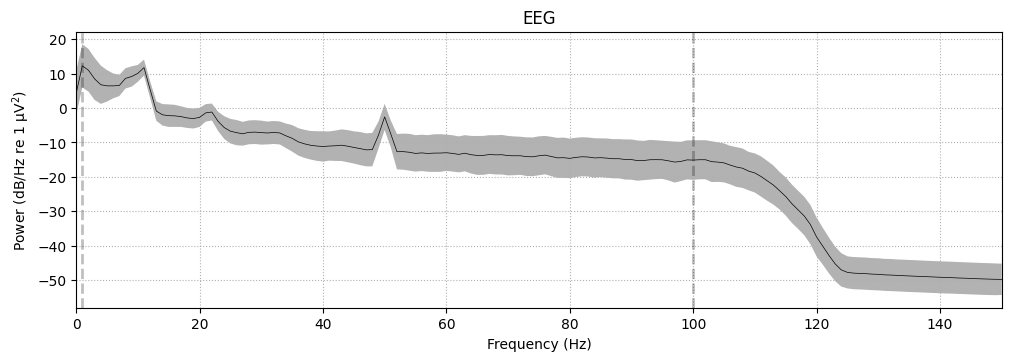

In [23]:
fig = filt_raw.compute_psd(fmax = 150).plot(
        average = True, amplitude = False, picks = "data", exclude = "bads"
)

Power line noise Ratio check

In [24]:
#Compute and compare power sprectral density(psd) in the regions near 50Hz
psd = filt_raw.compute_psd(fmin = 40, fmax = 60)
freqs = psd.freqs
psd_data = psd.get_data()

#Get index for 50Hz data and neighboring frequencies 
idx_50 = np.argmin(np.abs(freqs - 50))
idx_left = np.where((freqs >= 40) & (freqs < 48))[0]
idx_right = np.where((freqs > 52) & (freqs <= 60))[0]

#Get mean power for the frequencies and calculate the ratio: 50Hz / neighbors
power_50 = psd_data[:, idx_50].mean()
power_neighbors = np.concatenate([psd_data[:, idx_left], psd_data[:, idx_right]], axis = 1).mean()
power_ratio = power_50 / (power_neighbors + 1e-15) #No Divide by 0 error

if power_ratio > 2 :
    filt_raw.notch_filter(freqs = (50, 100, 150), method = "spectrum_fit")

Effective window size : 1.000 (s)
Filtering raw data in 1 contiguous segment
Removed notch frequencies (Hz):
     50.00 : 1056 windows
    100.00 : 1056 windows
    150.00 : 1056 windows


In [25]:
fig = filt_raw.compute_psd(fmax = 150).plot(
        average = True, amplitude = False, picks = "data", exclude = "bads"
)

Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


c:\Users\Iraklis Kolokas\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Set Common Average Reference

In [26]:
filt_raw = filt_raw.set_eeg_reference("average", projection = False)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Artifact removal 

In [27]:
#Set Biosemo 32 channel montage to plot correctly
montage = mne.channels.make_standard_montage(kind = "biosemi32")

rename_dict = dict(zip(filt_raw.ch_names, montage.ch_names)) #rename raw_data channel names to match the 
filt_raw.rename_channels(rename_dict)                        #biosemi32 channel names

<RawEDF | user_18_session_1.bdf, 33 x 350212 (171.0 s), ~88.2 MiB, data loaded>

In [28]:
filt_raw.set_montage(montage)

<RawEDF | user_18_session_1.bdf, 33 x 350212 (171.0 s), ~88.2 MiB, data loaded>

In [29]:
ica = ICA(n_components = 0.999, max_iter = "auto", method = "infomax", fit_params = dict(extended = True), random_state = 18) # 0.999 to show variance
ica.fit(filt_raw)
ica

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by explained variance: 28 components
Computing Extended Infomax ICA
Fitting ICA took 43.3s.


Method,infomax
Fit parameters,extended=Truemax_iter=500
Fit,186 iterations on raw data (350212 samples)
ICA components,28
Available PCA components,32
Channel types,eeg
ICA components marked for exclusion,—


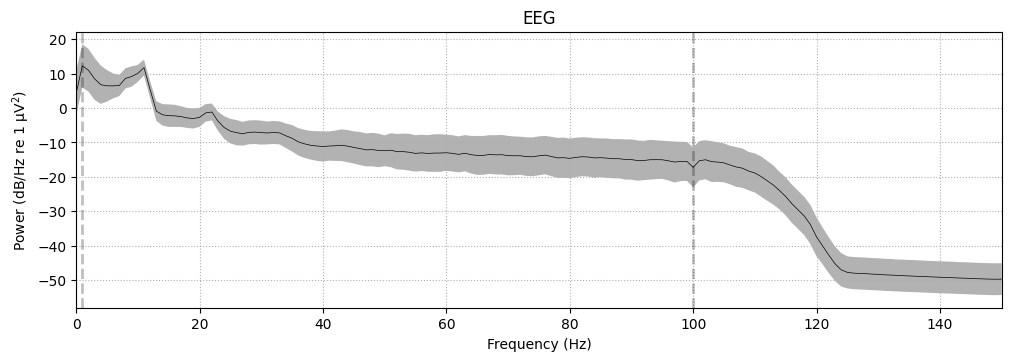

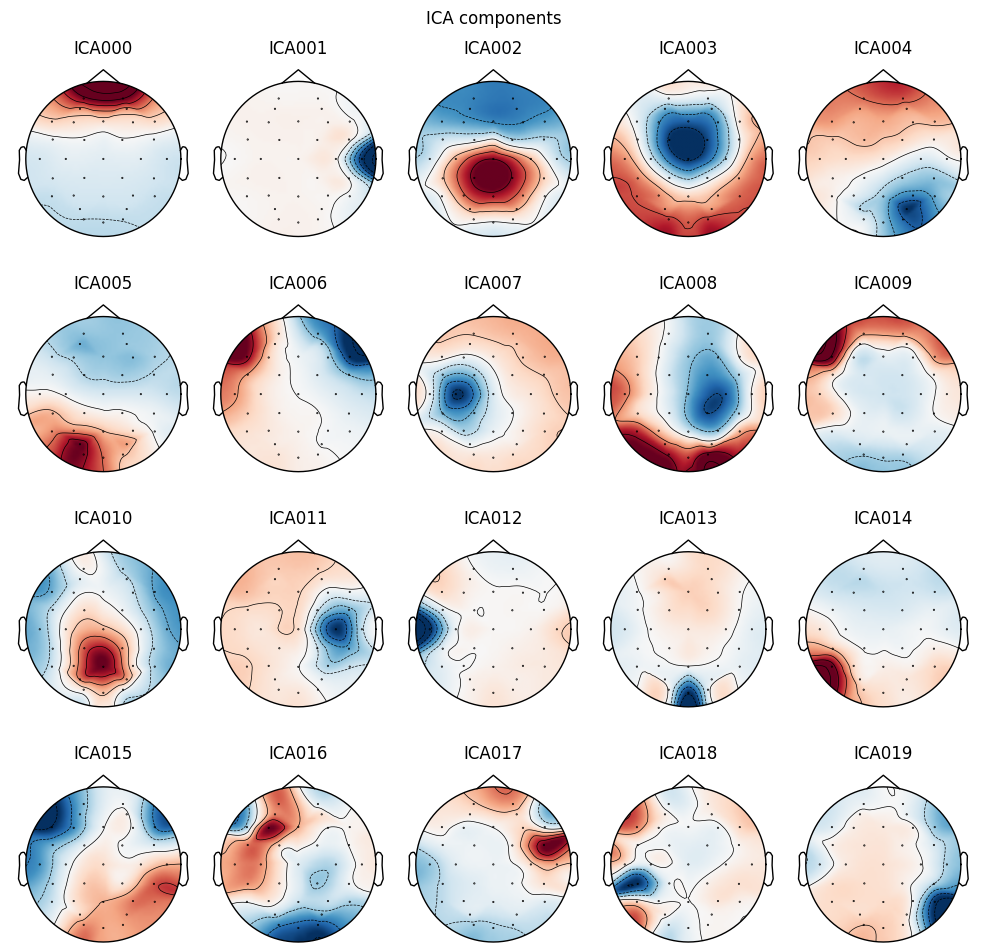

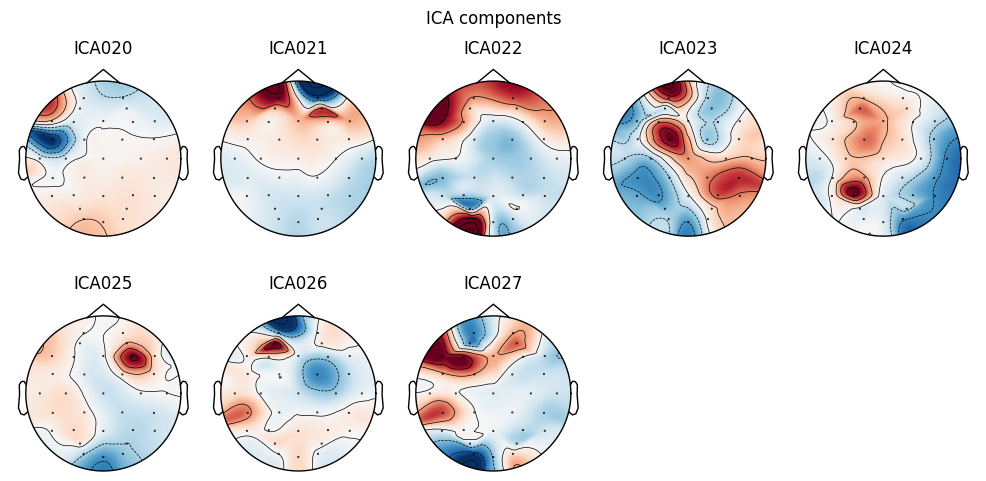

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x496 with 8 Axes>]

In [30]:
ica.plot_components()

Creating RawArray with float64 data, n_channels=28, n_times=350212
    Range : 31925 ... 382136 =     15.588 ...   186.590 secs
Ready.
Using matplotlib as 2D backend.


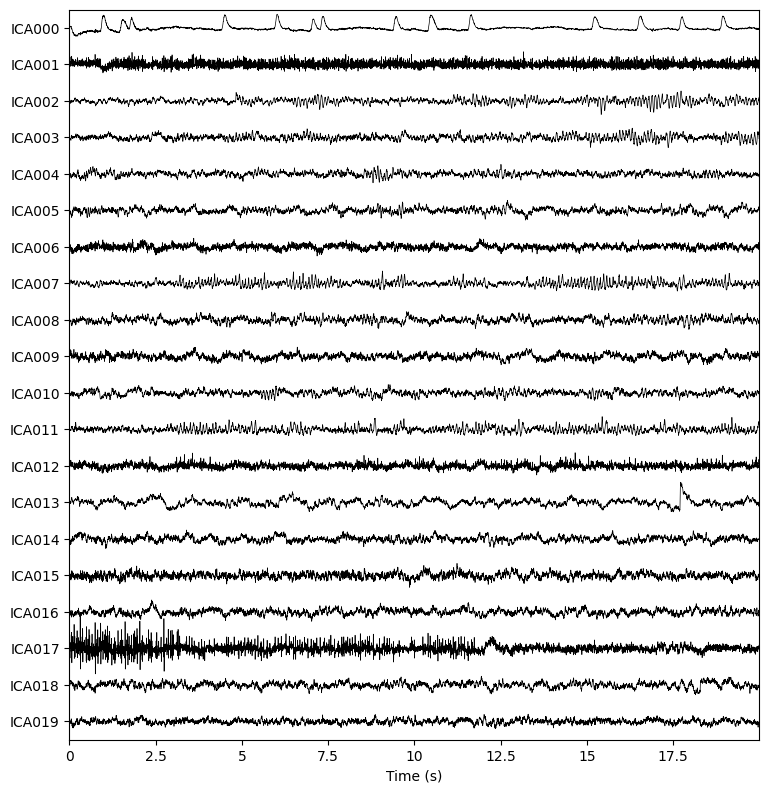

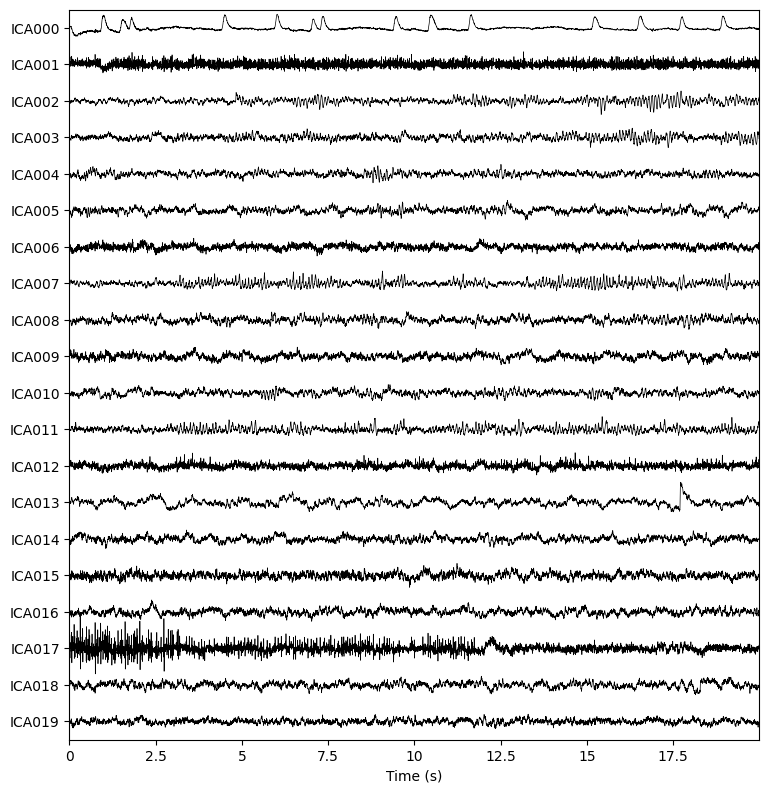

In [31]:
ica.plot_sources(filt_raw, show_scrollbars = False, show = True)

EOG artifacts with Fp reference

In [32]:
eog_inds, eog_scores = ica.find_bads_eog(filt_raw, ch_name = ["Fp1", "Fp2"])
if eog_inds:
    eog_inds = [int(x) for x in eog_inds]

Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25

ICALABEL to label ica components

In [33]:
ica_labels = mne_icalabel.label_components(filt_raw, ica, method = "iclabel")

In [34]:
print(ica_labels["labels"])
print(ica_labels["y_pred_proba"])

['eye blink', 'muscle artifact', 'brain', 'brain', 'brain', 'brain', 'eye blink', 'brain', 'brain', 'other', 'brain', 'brain', 'eye blink', 'brain', 'brain', 'other', 'brain', 'other', 'other', 'brain', 'other', 'eye blink', 'other', 'brain', 'brain', 'brain', 'other', 'other']
[0.9982487  0.9999908  0.9999994  0.99996674 0.99838185 0.9981142
 0.9222344  0.9994837  0.97188455 0.7202567  0.99837506 0.99823564
 0.5503108  0.60998964 0.78581524 0.6592489  0.9279444  0.9409642
 0.61167943 0.9107555  0.8298216  0.9163042  0.9035377  0.98125905
 0.6504711  0.7091438  0.80317086 0.7663919 ]


Compare EOG and ICALABEL results for eye-blink artifacts

In [35]:
iclabel_eye_components = [i for i, label in enumerate(ica_labels["labels"]) if label == "eye blink"]
overlap = set(iclabel_eye_components) & set(eog_inds)
only_iclabel = set(iclabel_eye_components) - set(eog_inds)
only_find_bads = set(eog_inds) - set(iclabel_eye_components)

print("overlap:", overlap)
print("Only in ICLabel:", only_iclabel)
print("Only in find_bads_eog:", only_find_bads)

overlap: {0}
Only in ICLabel: {12, 21, 6}
Only in find_bads_eog: set()


Find correct eog components

In [36]:
if bool(overlap) == 0:
    if eog_inds:
        eog_components = eog_inds
    else:
        eog_components = iclabel_eye_components
else:
    eog_components = list(overlap)

Artifact components to exclude

In [37]:
exclude_comp =  [i for i, label in enumerate(ica_labels["labels"]) if label not in ["brain", "other", "eye blink"]] + eog_components
exclude_comp.sort()

Plot filtered data without the excluded components

Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


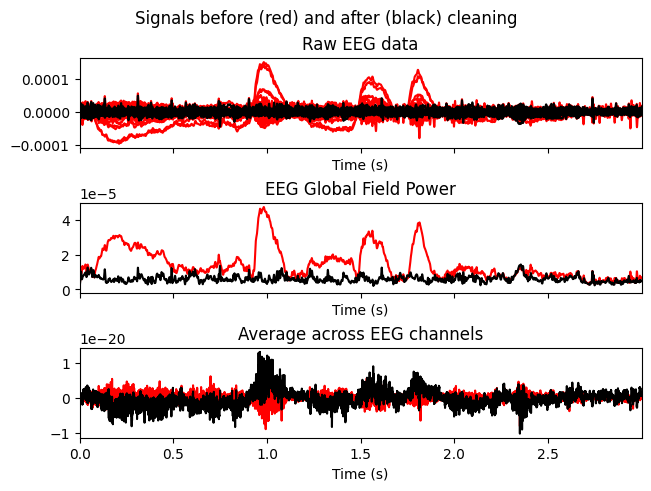

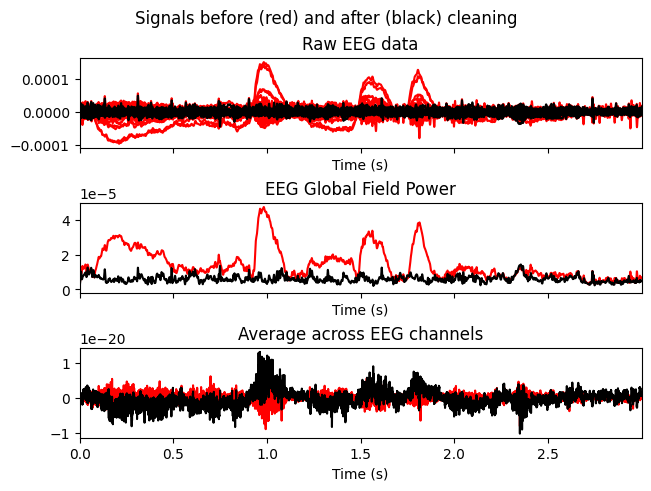

In [38]:
ica.plot_overlay(filt_raw, exclude = exclude_comp, picks = "eeg") # PROBLEM WITH AVERAGE ACROSS EEG CHANNELS

Resample

In [39]:
filt_raw.filter(l_freq = 0,h_freq = 70.0)
filt_raw.resample(256)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 387 samples (0.189 s)

Finding events on: Status
15 events found on stim channel Status
Event IDs: [2]
Finding events on: Status
15 events found on stim channel Status
Event IDs: [2]


<RawEDF | user_18_session_1.bdf, 33 x 43776 (171.0 s), ~11.1 MiB, data loaded>

Recalculate events

In [40]:
events = mne.find_events(filt_raw, stim_channel = "Status", shortest_event = 1)

Finding events on: Status
15 events found on stim channel Status
Event IDs: [2]


Drop Status channel in filt_raw.copy

In [41]:
extr_data = filt_raw.copy().pick(picks = "eeg")

Add correct labels to the events and save them to a txt file

In [42]:
with open(f"C:/Users/Iraklis Kolokas/Desktop/Thesis/stimuli sequence/{filename}.txt", "w") as f:
    for i in range(len(epochs)):
        if np.int64(i) in epochs_in_clusters[cl_500]:
            events[:, -1][i] = cl_500
            f.write(f"{cl_500} ")
        elif np.int64(i) in epochs_in_clusters[cl_2000]:
            events[:, -1][i] = cl_2000
            f.write(f"{cl_2000} ")
        elif np.int64(i) in epochs_in_clusters[cl_4000]:
            events[:, -1][i] = cl_4000
            f.write(f"{cl_4000} ")

In [43]:
print(events)
print(cl_500, cl_2000, cl_4000)

[[ 4503     0     2]
 [ 7319     0     1]
 [10058     0     1]
 [13104     0     0]
 [16484     0     2]
 [19325     0     0]
 [22679     0     0]
 [25495     0     0]
 [28874     0     2]
 [31587     0     2]
 [34660     0     1]
 [37527     0     2]
 [40471     0     1]
 [43236     0     0]
 [46538     0     1]]
0 1 2


In [44]:
epochs = mne.Epochs(extr_data, events = events, tmin = -0.3, tmax = 2.5, baseline = (None, 0), preload = True)

Not setting metadata
15 matching events found
Setting baseline interval to [-0.30078125, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15 events and 718 original time points ...
0 bad epochs dropped


Feature Extraction

In [45]:
#Get the data
x = epochs.get_data()
y = epochs.events[:, -1]

In [46]:
#convert epoch_data to torch tensor
x_tensor = torch.tensor(x, dtype = torch.float32)

In [47]:
#Check if the system has a GPU
cuda = torch.cuda.is_available()
device = "cuda" if cuda else "cpu"
if cuda:
    torch.backends.cudnn.benchmark = True 

In [48]:
#Initialization of the first model
model = EEGInceptionERP(
    n_chans = x.shape[1],
    n_outputs = len(np.unique(y)), #Required but will not matter since I will 
    n_times = x.shape[2]           #ignore the classification(last) layer
)

In [49]:
#Disable model's training behaviors (dropout, batch norm updates)
model.eval()

EEGInceptionERP(
  (ensuredims): Ensure4d()
  (dimshuffle): Rearrange('batch C T 1 -> batch 1 C T')
  (inception_block_1): InceptionBlock(
    (branches): ModuleList(
      (0): Sequential(
        (0): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=same)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
        (3): Dropout(p=0.5, inplace=False)
        (4): DepthwiseConv2d(8, 16, kernel_size=(32, 1), stride=(1, 1), padding=valid, groups=8, bias=False)
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (6): ELU(alpha=1.0)
        (7): Dropout(p=0.5, inplace=False)
      )
      (1): Sequential(
        (0): Conv2d(1, 8, kernel_size=(1, 32), stride=(1, 1), padding=same)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
        (3): Dropout(p=0.5, inplace=False)
        (4): DepthwiseCon

In [50]:
#Get features for the first model
#Remove the classification(last) layer of the (SL) model
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])

with torch.no_grad():
    features = feature_extractor(x_tensor)

c:\Users\Iraklis Kolokas\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1028.)
  return F.conv2d(


In [51]:
#Get the length of each epoch
_, _, epoch_length = epochs.get_data().shape

In [52]:
#Initialization of the second model
model2 = SignalJEPA(
    n_chans = len(extr_data.ch_names),
    chs_info = extr_data.info["chs"],
    n_times = epoch_length,
    sfreq = 256
)

c:\Users\Iraklis Kolokas\AppData\Local\Programs\Python\Python313\Lib\site-packages\braindecode\models\signal_jepa.py:1008: RuntimeWarning: divide by zero encountered in scalar divide
  xx = (x - x_min) / (x_max - x_min)
c:\Users\Iraklis Kolokas\AppData\Local\Programs\Python\Python313\Lib\site-packages\braindecode\models\signal_jepa.py:1008: RuntimeWarning: invalid value encountered in scalar divide
  xx = (x - x_min) / (x_max - x_min)


In [53]:
#Disable model's training behaviors (dropout, batch norm updates)
model2.eval()

SignalJEPA(
  (feature_encoder): _ConvFeatureEncoder(
    (0): Rearrange('b channels time -> (b channels) 1 time', channels=32)
    (1): Sequential(
      (0): Conv1d(1, 8, kernel_size=(32,), stride=(8,), bias=False)
      (1): Dropout(p=0.0, inplace=False)
      (2): GroupNorm(8, 8, eps=1e-05, affine=True)
      (3): GELU(approximate='none')
    )
    (2): Sequential(
      (0): Conv1d(8, 16, kernel_size=(2,), stride=(2,), bias=False)
      (1): Dropout(p=0.0, inplace=False)
      (2): GELU(approximate='none')
    )
    (3): Sequential(
      (0): Conv1d(16, 32, kernel_size=(2,), stride=(2,), bias=False)
      (1): Dropout(p=0.0, inplace=False)
      (2): GELU(approximate='none')
    )
    (4): Sequential(
      (0): Conv1d(32, 64, kernel_size=(2,), stride=(2,), bias=False)
      (1): Dropout(p=0.0, inplace=False)
      (2): GELU(approximate='none')
    )
    (5): Sequential(
      (0): Conv1d(64, 64, kernel_size=(2,), stride=(2,), bias=False)
      (1): Dropout(p=0.0, inplace=False)


In [54]:
#Extract features(embeddings)
with torch.no_grad():
    features2 = model2(x_tensor)

Save the features 

In [55]:
#Get user to add as label
user_id = filename.split("_")[1]

In [56]:
#Get acoustic stimuli sequence to add as label
stimuli_sequence = events[:, -1].astype(int).tolist()

In [57]:
np.savez(f"C:/Users/Iraklis Kolokas/Desktop/Thesis/Features/{filename}_features_1.npz", features = features, user_id = user_id, stimuli_sequence = stimuli_sequence)
np.savez(f"C:/Users/Iraklis Kolokas/Desktop/Thesis/Features/{filename}_features_2.npz", features = features2, user_id = user_id, stimuli_sequence = stimuli_sequence)